# Portfolio AI 3.1

       Written by Chris Waller (https://uk.linkedin.com/in/wallerchris)

**Desciption:**

This script allows an AI to 'learn' what the optimal long/short portfolio is. It does this by:
1. Taking expected returns. These are a combination of my intrinsic fundamental analysis and historic & market adjustments.
2. Taking expected correlations. These are the result of historic correlations and an adjustment to move correlations back to historic averages.
3. Simulating 10000 returns for each security via Monte Carlo. The simulator does this by randomising the returns and correlations for each period. These are randomised around the expected returns and correlations from steps 1) and 2). It then creates Cholesky Matrixes and random errors.
4. An AI learns which sets of long/short weights are through decision trees. For each AI portfolio, the AI starts off with a weight of 0% on each security. It then randomlly allocates x% to a security and looks at the risk & reward charateristics of new portfolio when put through the 10000 sims. If the portfolio is better it keeps the new x% weight, if it is worse it tries a -x% weight. This process repeats many times until an 'optimal' portfolio is reached.
5. ~30 AI portfolios are created this way. They are then filtered based factors such as their betas to the market. A final list of AI portfolios remains. These are ranked from best to worst.

**Significant updates from pervious version:**

1. Correlations now experience a 'regime change', where all correlations increase or degree by a non-linear 'regime'.
     - This is intended to mimic the fluctuations in the stock market's correlations over time. Historically, the correlation between stocks within the S&P 500 has had a mean of 0.6 and standard deviation of 0.1. The 'regime changes' in this model are an attempt to reflect this.
2. Market returns now have a negative 'fat tail'. Modelled using an inverse lognormal distribution.
3. Scenario testing added for portfolios.

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pandas.io.data as web
from pandas.io.data import DataReader
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime as dt
import random
import scipy
import scipy.linalg
from scipy import stats
import statsmodels.api as sm
from decimal import Decimal
import itertools
from itertools import product

%matplotlib inline 

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/io/data.py:33: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


Data for securities is drawn in from a separate excel doc. In the doc I have a list of securities and expected risk and reward charactersitics

In [2]:
xls_file = pd.ExcelFile('/Users/christopherwaller/Library/Mobile Documents/com~apple~CloudDocs/Last copy of Samsung Laptop files/Documents/Documents/Investment/Avalon/Portfolio.xlsx')
xls_portfolio_sheet = xls_file.parse('Portfolio')
portfolio_sheet = DataFrame(xls_portfolio_sheet)

In [3]:
symbols = list(portfolio_sheet.Ticker)
directions = list(portfolio_sheet.Direction)

Taking historic prices for securities from Yahoo Finance

In [4]:
historic_prices = DataFrame()

#gives pricing data since Jan-2010.
for sym in symbols:
    historic_prices[sym] = web.DataReader(sym, data_source='yahoo',
                              end=dt.datetime.now())['Adj Close']
    
historic_daily_returns = np.log(historic_prices/historic_prices.shift(1))

**Defining risk and reward functions.**
 - The 'risk' used in this model quantifies all negative return values, and the 'reward' all positive ones. See this illustration:

<img src="risk_reward_picture.png" alt="Drawing" style="width: 400px;"/>

In [5]:
def returns(stock, freq, start, end):
    daily_prices = web.get_data_yahoo(stock, start=start, end=end)['Adj Close']  
    dates = pd.date_range(start, end, freq=freq)
    prices_used = daily_prices.reindex(dates, method='ffill')
    price_change = np.log(prices_used/prices_used.shift(1)).dropna()
    return np.round((price_change),3)

#e.g: returns(symbols, 'Q', dt.datetime(1960,1,1), dt.datetime.now())

def returns_diff(stock, benchmark, freq, start, end):
    return (returns(stock, freq, start, end) - returns(benchmark, freq, start, end)).dropna()

#e.g: returns_diff('AAPL', '^GSPC', 'Q', dt.datetime(1960,1,1), dt.datetime.now())

def risk(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    return risk

def reward(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    return reward

def rr(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    rr = reward/abs(risk)
    return rr


def key_stats(stock, benchmark, freq, start, end):
    if benchmark == 'N/A':
        Data = returns(stock, freq, start, end)
    else:
        Data = returns_diff(stock, benchmark, freq, start, end)
    bins1=500
    counts, bins = np.histogram(Data, bins=bins1, range=(-1, 1))
    b = np.round(np.linspace(-1, 1, bins1), 2)
    rrs = [x * y / sum(counts) for x, y in zip(counts, bins)]
    risk = abs(sum([x for x in rrs if x <0]))
    reward = sum([x for x in rrs if x>0])
    rr = reward/abs(risk)
    key_stats = {
    'mean': np.mean(Data),
    'stdev': np.std(Data),
    'risk': risk,
    'reward': reward,
    'rr': rr
    }
    df_key_stats = np.round(DataFrame(key_stats, index=[stock]),3)
    cols = df_key_stats.columns.tolist()
    cols2 = cols[0:1] + cols[4:5] + cols[1:4]
    df_key_stats = df_key_stats[cols2].T
    return df_key_stats

def portfolio_risks(symbols, benchmark, freq, start, end):
    portfolio_risks = []
    for sym in symbols:
        try:
            portfolio_risks.append(risk(sym, benchmark, freq, start, end))
        except:
            portfolio_risks.append(0)
    return portfolio_risks

def portfolio_rewards(symbols, benchmark, freq, start, end):
    portfolio_rewards = []
    for sym in symbols:
        try:
            portfolio_rewards.append(reward(sym, benchmark, freq, start, end))
        except:
            portfolio_rewards.append(0)
    return portfolio_rewards

def portfolio_rrs(symbols, benchmark, freq, start, end):
    portfolio_rrs = []
    for sym in symbols:
        try:
            portfolio_rrs.append(rr(sym, benchmark, freq, start, end))
        except:
            portfolio_rrs.append(0)
    return portfolio_rrs

# 1) Finding expected risk and rewards for each security
Expected risk and rewards are calcuated *for each simulation* using a combination of:
1. 'Intrinsic' risk and reward - the result of my in-depth fundamentals work
2. 'Market' risk and reward - reflects historic charateristics for the S&P 500 index
3. 'Historic' risk and reward - reflects a securities historic charateristics

Pulling in 'intrinsic' risk and reward values. These are the result of in-depth fundamental research I have conducted on each security

In [6]:
intrinsic_risks = list(portfolio_sheet.risk)
intrinsic_rewards = list(portfolio_sheet.reward)

Assigning 'market' risk and reward values. Historically, the S&P 500 has had risk = 4%, reward = 11%, r/r = 2.75x

In [7]:
mkt_risk = [0.04] * len(symbols)
mkt_reward = [0.11] * len(symbols)

Collecting these different stats into a dataframe

In [8]:
def portfolio_stats(symbols, benchmark, freq, start, end):
    portfolio_stats = {
        'Direction': directions,
        'mkt_risk': mkt_risk,
        'hist_risk': portfolio_risks(symbols, benchmark, freq, start, end),
        'intrinsic_risk': intrinsic_risks,
        'mkt_reward': mkt_reward,
        'hist_reward': portfolio_rewards(symbols, benchmark, freq, start, end),
        'intrinsic_reward': intrinsic_rewards,
        #'rr': portfolio_rrs(symbols, benchmark, freq, start, end)
    }
    return portfolio_stats

df_portfolio = DataFrame(portfolio_stats(symbols, 'N/A', 'A', dt.datetime(2005,1,1), dt.datetime.now()), index=symbols)

Cleaning historical numbers

In [9]:
df_portfolio.ix[df_portfolio.hist_reward == 0, 'hist_reward'] = 0.11
df_portfolio.ix[df_portfolio.hist_risk == 0, 'hist_risk'] = 0.04

df_portfolio.ix[df_portfolio.hist_reward < 0.06, 'hist_reward'] = 0.06
df_portfolio.ix[df_portfolio.hist_risk < 0.02, 'hist_risk'] = 0.02

df_portfolio.ix[df_portfolio.hist_reward > 0.3, 'hist_reward'] = 0.3
df_portfolio.ix[df_portfolio.hist_risk > 0.3, 'hist_risk'] = 0.3


Adjusting intinsic value numbers by the 'investor factor'. This takes what risk and rewards that an investor *calculates/projects* from his intrinsic valuation work and adjusts it to the risks and rewards that they have *actually* achieved in their investment career. The better the investor, the less his projections need to be adjusted. (Of course, most people's *actual* results are very different to their *projected* results).

In this case, investor has outperformed the benchmark with r/r of 2.7x over his career.
Stock price reward has in reality been 1/3 of projected intrinsic valuations, and risk 2/3.

 - The historic projected intrinsic reward = 61%, reality = 61 x 1/3 = 20.3%
 - The historic projected intrinsic risk = 5.4%, reality = 5.4 x 2/3 = 3.6%
 - The historic intrinsic r/r = 11.3x, reality = 20.3/3.6 = 5.6x

In [10]:
investor_mean = 0.132
investor_std = 0.314
investor_rr = 2.8
investor_certainty_reward = 0.33
investor_certainty_risk = 0.67

In [11]:
df_portfolio.ix[df_portfolio.Direction == 'Long', 'intrinsic_reward'] = df_portfolio['intrinsic_reward'] * investor_certainty_reward
df_portfolio.ix[df_portfolio.Direction == 'Long', 'intrinsic_risk'] = df_portfolio['intrinsic_risk'] * investor_certainty_risk

df_portfolio.ix[df_portfolio.Direction == 'Short', 'intrinsic_reward'] = df_portfolio['intrinsic_reward'] * investor_certainty_risk
df_portfolio.ix[df_portfolio.Direction == 'Short', 'intrinsic_risk'] = df_portfolio['intrinsic_risk'] * investor_certainty_reward

Creating expected numbers by placing different loadings on each of intrinsic, market, and historic numbers for each security

In [12]:
#loadings
H = 0.2 #historic
M = 0.2 #market
I = 0.6 #Intrinsic

exp_risk = M*df_portfolio['mkt_risk'] + H*df_portfolio['hist_risk'] + I*df_portfolio['intrinsic_risk']
exp_reward = M*df_portfolio['mkt_reward'] + H*df_portfolio['hist_reward'] + I*df_portfolio['intrinsic_reward']
exp_rr = exp_reward/exp_risk

In [13]:
target_risks = list(exp_risk)
target_rewards = list(exp_reward)

In [14]:
df_portfolio['E_risk'] = exp_risk
df_portfolio['E_rwrd'] = exp_reward
df_portfolio['E_rr'] = exp_rr

In [15]:
cols = ['E_rr', 'E_rwrd', 'E_risk', 'intrinsic_reward', 'intrinsic_risk', 'hist_reward', 'hist_risk', 'mkt_reward', 'mkt_risk']
df_portfolio = df_portfolio[cols]
col2 = ['Direction']
df_portfolio = pd.concat([np.round(df_portfolio,2), DataFrame(directions, index=symbols, columns=col2)], axis=1)
cols2 = ['Direction', 'E_rr', 'E_rwrd', 'E_risk', 'intrinsic_reward', 'intrinsic_risk', 'hist_reward', 'hist_risk', 'mkt_reward', 'mkt_risk']
df_portfolio = df_portfolio[cols2]

The resulting dataframe shows the expected numbers and each of intrinsic, market, and historic numbers for each security

In [16]:
df_portfolio

,Direction,E_rr,E_rwrd,E_risk,intrinsic_reward,intrinsic_risk,hist_reward,hist_risk,mkt_reward,mkt_risk
^GSPC,Long,2.54,0.11,0.04,0.11,0.04,0.10,0.05,0.11,0.04
OIL,Long,0.70,0.09,0.13,0.10,0.12,0.06,0.26,0.11,0.04
NTT,Long,7.44,0.20,0.03,0.27,0.01,0.11,0.06,0.11,0.04
JNJ,Long,6.58,0.21,0.03,0.29,0.03,0.09,0.02,0.11,0.04
HCA,Long,5.15,0.21,0.04,0.22,0.05,0.30,0.02,0.11,0.04
NXTM,Short,0.85,0.09,0.11,0.06,0.11,0.20,0.18,0.11,0.04
GOOGL,Long,2.80,0.14,0.05,0.13,0.04,0.22,0.09,0.11,0.04
CRST.L,Long,9.78,0.27,0.03,0.33,0.02,0.24,0.04,0.11,0.04
BVS.L,Long,2.14,0.13,0.06,0.13,0.05,0.14,0.10,0.11,0.04
TW.L,Long,1.39,0.11,0.08,0.06,0.08,0.26,0.11,0.11,0.04


# 2) Expected correlations
Expected correlations are calculated *for each simulation* using a combination of:
1. Historic correlations
2. Adjusting average correlations back toward mid-cycle average

Historic correlations - trailing 1-year

In [17]:
historic_correlations = DataFrame(historic_daily_returns[-251:].corr())

Ability to look at how the correlation of one pair has changed over time

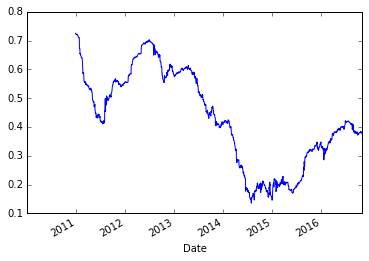

In [18]:
def rolling_corr(x, y, z):
    pd.rolling_corr(historic_daily_returns[x], historic_daily_returns[y], z).plot()

    
rolling_corr('^GSPC', 'OIL', 250)

Adjusting correlations back towards mid-cycle. The S&P 500 has historically had a correlation between stocks of N ~ (0.6, 0.1)

In [19]:
current_corr = np.mean(historic_correlations['^GSPC']) #current average corr to S&P
distance_from_midcycle = 0.6 - current_corr
adjustment_factor = min(2.0, 1.0/(1.0 + 2 * distance_from_midcycle)) #adjusting correlations back to cycle mean, allowing for some persistence.

cycle_adjustment = lambda x: min(max(0.05, x**(adjustment_factor) ), 1) #add distance_from_midcycle

exp_corrs = historic_correlations.applymap(cycle_adjustment)

Expected correlations

In [20]:
print 'Trailing 1 year corr to S&P:', np.round(current_corr, 2)
print 'Distance to mid-cycle (0.6):', np.round(distance_from_midcycle, 2)
print 'Exp corr to S&P used:', np.round(np.mean(exp_corrs['^GSPC']), 2)
np.round(exp_corrs, 2)

Trailing 1 year corr to S&P: 0.43
Distance to mid-cycle (0.6): 0.17
Exp corr to S&P used: 0.52


,^GSPC,OIL,NTT,JNJ,HCA,NXTM,GOOGL,CRST.L,BVS.L,TW.L,...,OEC,URI,HP,APC,XEC,SWN,WPX,SM,EPE,GAS.MC
^GSPC,1.00,0.49,0.52,0.71,0.63,0.45,0.73,0.49,0.52,0.52,...,0.50,0.64,0.64,0.66,0.65,0.34,0.52,0.53,0.39,0.56
OIL,0.49,1.00,0.28,0.22,0.27,0.23,0.19,0.30,0.28,0.28,...,0.42,0.43,0.67,0.61,0.68,0.45,0.60,0.56,0.58,0.23
NTT,0.52,0.28,1.00,0.43,0.33,0.28,0.47,0.05,0.05,0.05,...,0.05,0.15,0.27,0.32,0.28,0.12,0.21,0.21,0.08,0.26
JNJ,0.71,0.22,0.43,1.00,0.37,0.38,0.53,0.21,0.20,0.22,...,0.13,0.37,0.35,0.36,0.47,0.05,0.27,0.21,0.14,0.39
HCA,0.63,0.27,0.33,0.37,1.00,0.35,0.44,0.35,0.44,0.39,...,0.38,0.51,0.42,0.50,0.47,0.40,0.45,0.45,0.38,0.46
NXTM,0.45,0.23,0.28,0.38,0.35,1.00,0.33,0.22,0.23,0.23,...,0.32,0.37,0.21,0.29,0.20,0.15,0.22,0.26,0.18,0.34
GOOGL,0.73,0.19,0.47,0.53,0.44,0.33,1.00,0.33,0.37,0.39,...,0.28,0.20,0.29,0.36,0.32,0.05,0.13,0.19,0.05,0.39
CRST.L,0.49,0.30,0.05,0.21,0.35,0.22,0.33,1.00,0.92,0.93,...,0.42,0.46,0.30,0.36,0.33,0.22,0.31,0.26,0.24,0.47
BVS.L,0.52,0.28,0.05,0.20,0.44,0.23,0.37,0.92,1.00,0.94,...,0.47,0.48,0.32,0.34,0.35,0.22,0.31,0.29,0.23,0.54
TW.L,0.52,0.28,0.05,0.22,0.39,0.23,0.39,0.93,0.94,1.00,...,0.38,0.45,0.29,0.30,0.32,0.18,0.28,0.26,0.18,0.56


# 3) Monte Carlo Simulation
n simulations are made using the data from above as mean values. Steps here are:
1. n random errors are created. These are the returns for each security in each year
2. A correlation matrix is created for each year and adjusted by a 'regime change'
3. Cholesky matrixes are created for each year using 1) and 2).

In [21]:
n_sims = 10000

Using the inverse lognormal distribution for errors so that the negative tail is 'fat'.

In [22]:
errors = DataFrame(1 - np.random.lognormal(0, 0.163, (n_sims, len(symbols)))) 

Applying a 'regime change' to correlations for each year.

In [23]:
n = n_sims 

regimes = []
for x in range(n):
    x = np.random.normal(0, 0.1) 
    regimes.append(x)

Increasing correlations used in simulations because some correlation is lost from making calibration adjustments

In [24]:
corr_adj = [x+0.1 for x in regimes]

Simulating correlation matrixes for each year. The matrix must by positive-definite to be a cholesky matrix, so if the first eigenvalue for the correlation matrix is negative, the nearest positive is found.

In [25]:
def nearPSD(A,epsilon=0):  #delete =0?
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,epsilon))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

exp_corrs2 = []
for p in range(n):
    e_corr = exp_corrs.applymap(lambda x: min(max(0.05, (x ** (1 - 3 * float(corr_adj[p])/1.0))), 1)) 
    if np.linalg.eigvalsh(scipy.array(exp_corrs.applymap(lambda x: min(max(0.05, x ** ((1 - 3 * float(corr_adj[p]))/1.0)), 1)).values.T.tolist()))[0]>0:
        e_corr = e_corr
    else:
        if min(np.linalg.eig(nearPSD(e_corr,0.001))[0])>0: #if e_corr is not a positive definite matrix then find nearest one
            e_corr = nearPSD(e_corr,0.001)
        else:
            #if still doesn't work than just use exp_corrs (happens v.v. infrequently so doesn't skew results):
            e_corr = exp_corrs
    exp_corrs2.append(DataFrame(e_corr, columns=symbols, index=symbols))



Creating cholesky matrixes

In [26]:
As = []
for p in range(n):
    a = scipy.array(exp_corrs2[p].values.T.tolist())
    As.append(a)

Ls = []
for p in range(n):
    l = scipy.linalg.cholesky(As[p], lower=True)
    Ls.append(l)

Us = []
for p in range(n):
    u = scipy.linalg.cholesky(As[p], lower=False)
    Us.append(u)  

Checking that correlation results make sense. The difference between correlations for the 83rd percentile and the 50th percentile should be ~0.16, but in this case are targetted to be ~0.2 because some correlation is lost in subsequent calibration.

In [27]:
Cor_spx = []
for p in range(n):
    x = np.mean(exp_corrs2[p]['^GSPC']) 
    Cor_spx.append(x)

print 'Exp average corr to S&P:', np.round(np.mean(exp_corrs['^GSPC']), 2)
print 'Model corr to S&P for percentile:', np.round(np.percentile(Cor_spx, 83), 2)
print 'Diff:', np.round(np.percentile(Cor_spx, 83) - np.mean(exp_corrs['^GSPC']), 2)

Exp average corr to S&P: 0.52
Model corr to S&P for percentile: 0.73
Diff: 0.21


Similarly, correlation between securities in the model should be ~0.1 higher than expected at this stage.

In [28]:
corr_pair = []
stock_a = 'TSCO.L'
stock_b = 'SBRY.L'

for p in range (n):
    x = exp_corrs2[p][stock_a][stock_b]
    corr_pair.append(x)
print 'Expected corr between pair:', np.round(exp_corrs[stock_a][stock_b], 2)
print 'Actual average corr in model:', np.round(np.mean(corr_pair), 2)
print 'Actual std of corr in model:', np.round(np.std(corr_pair), 2)

Expected corr between pair: 0.65
Actual average corr in model: 0.74
Actual std of corr in model: 0.09


Creating correlated errors by combining the simulated errors and the simulated cholesky matrixes

In [29]:
correlated_errors = []
for p in range(n):
    c = np.dot(errors.loc[p], Us[p])
    correlated_errors.append(c)

correlated_errors = DataFrame(correlated_errors, columns=symbols)

# 4) Calibration
The correlated errors are now calibrated so that their distributions fit the expected risk and reward values from above. 

In [30]:
weights = 1.0/n_sims
weights = [weights] * n_sims

Randomly assigning an adjustment factor to each return: random.uniform(0, 1) x -4.0 for *negative returns*, and x +4.0 for *positive ones*. The returns thus spread out to the correct fit. 

In [31]:
def calibrate(data, target_risk, target_reward):
    model = []
    actual_risk = abs(sum([x*y for x, y in zip(data, weights) if x <0]))
    actual_reward = abs(sum([x*y for x, y in zip(data, weights) if x >0])) 
    for x in data:              
        if x < 0: 
            r1 = random.uniform(0, 1) * -4.0 #adjustment
            d = x + r1*np.random.normal(target_risk - actual_risk, 0.02) #adding some variance so there isn't clustering around negative or positive means
        else:
            r2 = random.uniform(0, 1) * 4.0
            d = x + r2*np.random.normal(target_reward - actual_reward, 0.02)
        model.append(d)
    return model

In [32]:
def sim(data, n):
    model = []
    for p in range(n): 
        d = calibrate(data[symbols[p]], target_risks[p], target_rewards[p])
        model.append(d)
    return model

In [33]:
sim_output = DataFrame(sim(correlated_errors, len(symbols)), index=symbols).T  

In [34]:
def model_risk(model, weights):
    return abs(sum([x*y for x, y in zip(model, weights) if x <0]))

def model_reward(model, weights):
    return abs(sum([x*y for x, y in zip(model, weights) if x >0]))

def model_rr(model, weights):
    return model_reward(model, weights)/model_risk(model, weights)

Checking that the results of the sim fit the expected risk and rewards

In [35]:
test = 'SHLD'

print 'Expected reward:', df_portfolio['E_rwrd'][test]
print 'Acutal reward:', np.round(model_reward(sim_output[test], weights), 2)
print 'Diff:', np.round(model_reward(sim_output[test], weights), 2) - df_portfolio['E_rwrd'][test]
print ''

print 'Expected risk:', df_portfolio['E_risk'][test]
print 'Acutal risk:', np.round(model_risk(sim_output[test], weights), 2)
print 'Diff:', np.round(model_risk(sim_output[test], weights), 2) - df_portfolio['E_risk'][test]

Expected reward: 0.05
Acutal reward: 0.06
Diff: 0.01

Expected risk: 0.27
Acutal risk: 0.28
Diff: 0.01


# 5) AI
A basic AI now 'learns' the optimal weights for a portfolio. The process is done ~30 times to get a range of 'optimal' weights for analysis.

The AI learns through decision trees. It starts with a portfolio with a weight of 0 on each security. It then randomly assigns a positive weight to one and sees how the new portfolio would have performed using the simulations above. If the reward/risk is better it keeps the weight. If not, it tests whether the portfolio would have been better with a negative weight on the security. If yes, it keeps the negative weight. If not, is moves on with no additional weight on that security. This process is done for each stock, always in a random order and with initial additional weights set at +/1 10% then falling to +/- 1% The max/min weight that can be applied to a security is +/- 24% 

In [36]:
def learn_weights(incoming_ws, w_tested, n_stocks): #ws = weights, w_tested=0.1, n_stocks = len(symbols)
    r = [i for i in range(len(symbols))]
    random.shuffle(r) #shuffling the order of symbols so that function goes through them at random
    length = [1.0/n_sims]*n_sims
    model_rrs = [0]*(n_stocks) 
    ws = [i for i in incoming_ws]
    for p in range(n_stocks):     
        ws[r[p]] += w_tested #add a weight
        weighted_output = sim_output*ws
        prets = weighted_output.sum(axis=1) #n number of portolio sims with the ws from above
        model_rrs[p] = model_rr(prets, length)
        if model_rrs[p] == max(model_rrs):
            ws[r[p]] += 0
        else:
            ws[r[p]] += -w_tested*2 #subtracting added weight, then making it negative?? should this be done separately??
            weighted_output = sim_output*ws
            prets = weighted_output.sum(axis=1) #n number of portolio sims with the ws from above
            model_rrs_test = 0
            model_rrs_test = model_rr(prets, length) 
            if model_rrs_test >= max(model_rrs): #testing if shorting stock gives better r/r then previous max
                ws[r[p]] += 0
            else: #if neither short nor long increases r/r
                ws[r[p]] += w_tested #add back weight so weight now 0.
    return ws

def ai_portfolios(ai_sims): #ai_sims = n number of simmed portfolios
    ai_weights = []
    s1=s2=s3=s4=s5=s6= [0] * len(symbols)
    for i in range(ai_sims): #this is why it can only do len(symbol) portfolios!!!!!!!!!!!!!:
        s1[i] = learn_weights([0] * len(symbols), 0.1, len(symbols))
        s2[i] = learn_weights(s1[i], 0.05, len(symbols))
        s3[i] = learn_weights(s2[i], 0.03, len(symbols))
        s4[i] = learn_weights(s3[i], 0.03, len(symbols))
        s5[i] = learn_weights(s4[i], 0.02, len(symbols))
        s6[i] = learn_weights(s5[i], 0.01, len(symbols))
        ai_weights.append(s6[i])
    return ai_weights

ai_n = len(symbols)
ai_ports = np.round(DataFrame(ai_portfolios(ai_n), columns=symbols), 2)

# 6) Cleaning portfolio results
Portfolios are now adjusted so that their Betas and weightings are acceptable. Unacceptable portfolios are filtered out.

Calculating the actual correlations and betas from simulations

In [37]:
actual_corrs = np.round(DataFrame(sim_output.corr()), 2)
actual_betas = np.round(DataFrame(sim_output.cov()/sim_output.var()), 2)

Testing to see whether expected and actual correlations from the simulations are similar. They are unlikely to be identifcal but should be roughly similar - they will be higher than expected for some securities and lower for others.

In [38]:
test = '^GSPC'
print 'Expected average correlations:', np.round(np.mean(exp_corrs[test]), 2)
print 'Actual average correlations:', np.round(np.mean(actual_corrs[test]), 2)

Expected average correlations: 0.52
Actual average correlations: 0.54


Calculating portfolio betas

In [39]:
def p_betas(actual_betas, data, n):
    model = []
    for p in range(n): #change to len(symbols)
        d = [sum(data.T[p] * actual_betas)]
        model.append(d)
    return model

mkt_betas = DataFrame(p_betas(actual_betas['^GSPC'], ai_ports, ai_n), columns=['Mkt β'])
oil_betas = DataFrame(p_betas(actual_betas['OIL'], ai_ports, ai_n), columns=['Oil β'])

Adjusting portfolio weights so that portfolio betas = 0
  - Oil beta is adjusted first because the final beta adjusted is what will be 0.
  - Oil beta to market is also lower than market beta to oil, so adjusting oil first requires less subsequent weighting on market to offset it. (Keeps weights on market and oil to a minimum).
  - Use a correction factor. Factor of 1 gives portfolio beta = 0 but allocates more to the weights of the S&P and Oil.

In [40]:
correction_factor = 1
for p in range(len(ai_ports)):
    ai_ports.loc[p]['OIL'] += correction_factor * -oil_betas.loc[p].values 
    ai_ports.loc[p]['^GSPC'] += correction_factor * -mkt_betas.loc[p].values + correction_factor * oil_betas.loc[p].values * actual_betas['OIL']['^GSPC'] #adding offsetting term

Recalculating portfolio betas post adjustments

In [41]:
mkt_betas = DataFrame(p_betas(actual_betas['^GSPC'], ai_ports, ai_n), columns=['Mkt β'])
oil_betas = DataFrame(p_betas(actual_betas['OIL'], ai_ports, ai_n), columns=['Oil β'])

Calculating portfolio risks and rewards

In [42]:
def p_rewards(weights, n): #weights=ai_ports, n=ai_n
    model = []
    for p in range(n): #change to len(symbols)
        length = [1.0/n_sims]*n_sims
        weighted_output = weights.T[p] * sim_output
        prets = weighted_output.sum(axis=1)
        model.append(model_reward(prets, length))
    return model

def p_risks(weights, n): #weights=ai_ports, n=ai_n
    model = []
    for p in range(n): #change to len(symbols)
        length = [1.0/n_sims]*n_sims
        weighted_output = weights.T[p] * sim_output
        prets = weighted_output.sum(axis=1)
        model.append(model_risk(prets, length))
    return model

p_rewards = DataFrame(p_rewards(ai_ports, ai_n), columns=['Reward'])
p_risks = DataFrame(p_risks(ai_ports, ai_n), columns=['Risk'])

Removing unsuitable portfolios

In [43]:
sum_output = np.round(pd.concat([p_rewards, p_risks, mkt_betas, oil_betas, ai_ports], axis=1).T, 2)

sum_output = sum_output.T[sum_output.T['Mkt β'] > -0.2].T
sum_output = sum_output.T[sum_output.T['Mkt β'] < 0.2].T

sum_output = sum_output.T[sum_output.T['^GSPC'] > -0.2].T
sum_output = sum_output.T[sum_output.T['^GSPC'] < 0.2].T

sum_output = sum_output.T[sum_output.T['Oil β'] > -0.2].T
sum_output = sum_output.T[sum_output.T['Oil β'] < 0.2].T

sum_output = sum_output.T[sum_output.T['OIL'] > -0.2].T
sum_output = sum_output.T[sum_output.T['OIL'] < 0.2].T

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1122: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


# 7) Portfolio analysis
Acceptable portfolios are collected and their risks, rewards, betas, average weight on each securities and stdev of these weights are analysed

In [44]:
single_stock_characteristics = pd.concat([df_portfolio[['E_rr','E_rwrd', 'E_risk']],actual_betas['^GSPC'], actual_betas['OIL']], axis=1)
single_stock_characteristics.columns = ['E_rr', 'E_rwrd', 'E_risk', 'Mkt β', 'Oil β']

In [45]:
means = np.round(DataFrame(sum_output.mean(axis=1), columns=['μ']), 2)
stds = np.round(DataFrame(sum_output.std(axis=1), columns=['σ']), 2)

sum_output_sorted = sum_output.T.sort_values('Reward', ascending=True).T #should sort by rr but not representative.

port_characteristics = pd.concat([means, stds], axis=1)
blank_column = DataFrame([""]*len(sum_output), index=sum_output.index, columns=[''])
port_summary = pd.concat([port_characteristics, blank_column, single_stock_characteristics, blank_column, sum_output_sorted], axis=1)
port_summary = port_summary.replace(np.nan,' ', regex=True)

/Users/christopherwaller/anaconda/lib/python2.7/site-packages/pandas/core/index.py:1907: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)


Summary

In [46]:
print "PORTFOLIO AI RESULTS"
print "Number of sims for each stock:", n_sims
print "Number of portfolios sims:", ai_n
print "Number of portfolios sims retained:", len(sum_output.columns)
port_summary

PORTFOLIO AI RESULTS
Number of sims for each stock: 10000
Number of portfolios sims: 31
Number of portfolios sims retained: 12


,μ,σ,,E_rr,E_rwrd,E_risk,Mkt β,Oil β,,13,...,16,24,20,18,15,2,17,28,19,8
Mkt β,-0.00,0.01,,,,,,,,-0.01,...,-0.01,-0.00,-0.01,-0.01,-0.01,-0.01,-0.00,-0.00,0.00,0.00
Oil β,-0.09,0.02,,,,,,,,-0.07,...,-0.07,-0.07,-0.07,-0.09,-0.09,-0.10,-0.09,-0.11,-0.10,-0.11
Reward,0.28,0.04,,,,,,,,0.21,...,0.25,0.25,0.26,0.27,0.28,0.29,0.30,0.32,0.33,0.34
Risk,0.00,0.00,,,,,,,,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
^GSPC,-0.12,0.03,,2.54,0.11,0.04,1,0.42,,-0.09,...,-0.11,-0.11,-0.10,-0.14,-0.19,-0.11,-0.16,-0.09,-0.13,-0.14
OIL,0.06,0.02,,0.7,0.09,0.13,0.74,1,,0.02,...,0.09,0.06,0.07,0.02,0.05,0.07,0.07,0.03,0.08,0.06
NTT,0.14,0.03,,7.44,0.2,0.03,0.75,0.4,,0.11,...,0.10,0.13,0.13,0.13,0.18,0.12,0.14,0.19,0.14,0.21
JNJ,0.12,0.02,,6.58,0.21,0.03,0.95,0.35,,0.11,...,0.11,0.12,0.10,0.12,0.09,0.09,0.15,0.12,0.12,0.17
HCA,0.15,0.03,,5.15,0.21,0.04,0.92,0.41,,0.11,...,0.12,0.12,0.13,0.18,0.20,0.15,0.16,0.16,0.14,0.19
NXTM,-0.10,0.05,,0.85,0.09,0.11,0.64,0.33,,-0.04,...,-0.11,-0.08,-0.06,-0.12,-0.08,-0.14,-0.04,-0.15,-0.15,-0.16


# 8) Further analysis
A portfolio is selected (usually the model portfolio) for further analysis

Setting model portfolio to the one with the 3rd highest reward (first couple sometimes have 'unusual' charateristics).

In [47]:
model_portfolio = port_summary.columns[-3:-2][0]
print 'Portfolio', model_portfolio, 'is model portfolio'

Portfolio 28 is model portfolio


Picking a portfolio to do further testing on

In [48]:
test_port1 = model_portfolio

Comparison of portfolio vs others

In [49]:
port_table = DataFrame(port_summary[['E_rr','', 'μ','σ','',test_port1]])
port_table

,E_rr,,,μ,σ,,,28
Mkt β,,,,-0.00,0.01,,,-0.00
Oil β,,,,-0.09,0.02,,,-0.11
Reward,,,,0.28,0.04,,,0.32
Risk,,,,0.00,0.00,,,0.00
^GSPC,2.54,,,-0.12,0.03,,,-0.09
OIL,0.7,,,0.06,0.02,,,0.03
NTT,7.44,,,0.14,0.03,,,0.19
JNJ,6.58,,,0.12,0.02,,,0.12
HCA,5.15,,,0.15,0.03,,,0.16
NXTM,0.85,,,-0.10,0.05,,,-0.15


Calculating yearly returns for portfolio

In [50]:
yearly_returns = (ai_ports.T[test_port1]*sim_output).sum(axis=1)

Comparison table vs S&P returns, Oil returns, market correlations

In [51]:
spx = sim_output['^GSPC']
oil = sim_output['OIL']
corr_spx = DataFrame(Cor_spx, index=range(n_sims), columns=['corr_spx'])

comp_df = np.round(pd.concat([spx, oil, corr_spx, yearly_returns], axis=1), 2)
comp_df.columns = ['S&P', 'Oil', 'S&P ρ', test_port1]

Regressing portfolio returns against betas

In [52]:
x = np.column_stack((list(comp_df['S&P'].values), list(comp_df['Oil'].values), list(comp_df['S&P ρ'].values)))
x = sm.add_constant(x)
y = list(comp_df[test_port1].values)

avalon = sm.OLS(y, x).fit()
print avalon.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     207.7
Date:                Tue, 01 Nov 2016   Prob (F-statistic):          1.10e-130
Time:                        14:22:36   Log-Likelihood:                 5656.0
No. Observations:               10000   AIC:                        -1.130e+04
Df Residuals:                    9996   BIC:                        -1.128e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.3103      0.008     38.745      0.0

Plotting correlation graphs vs the S&P, oil, correlations, and single securities

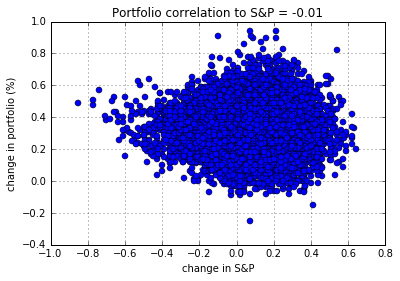

In [53]:
test = 'S&P'
x = comp_df[test]
y = comp_df[test_port1]
plt.plot(x, y, 'bo')
plt.xlabel('change in %s' % test) 
plt.ylabel('change in portfolio (%)')
plt.title('Portfolio correlation to %s = %s' % (test, (np.round(np.corrcoef(comp_df[test], comp_df[test_port1])[0][1], 2))))
plt.grid(True)

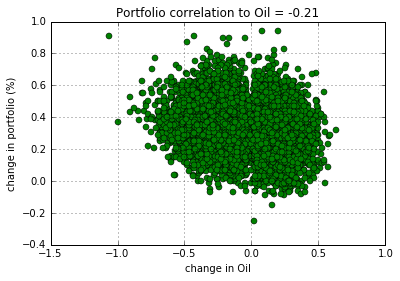

In [54]:
test = 'Oil'
x = comp_df[test]
y = comp_df[test_port1]
plt.plot(x, y, 'go')
plt.xlabel('change in %s' % test) 
plt.ylabel('change in portfolio (%)')
plt.title('Portfolio correlation to %s = %s' % (test, (np.round(np.corrcoef(comp_df[test], comp_df[test_port1])[0][1], 2))))
plt.grid(True)

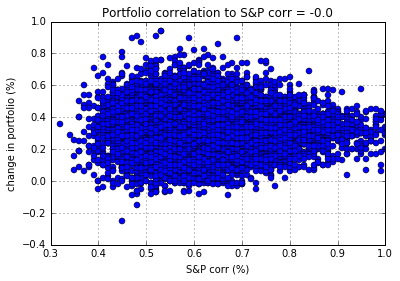

In [55]:
x = comp_df['S&P ρ']
y = comp_df[test_port1]
plt.plot(x, y, 'bo')
plt.xlabel('S&P corr (%)')
plt.ylabel('change in portfolio (%)')
plt.title('Portfolio correlation to S&P corr = %s' % (np.round(np.corrcoef(comp_df['S&P ρ'], comp_df[test_port1])[0][1], 2)))
plt.grid(True)

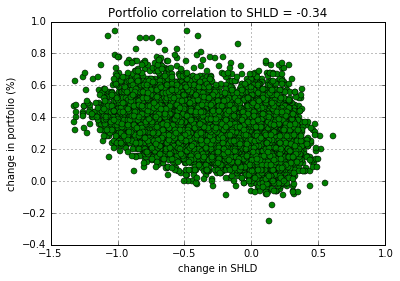

In [56]:
test = 'SHLD'
x = sim_output[test]
y = comp_df[test_port1]
plt.plot(x, y, 'go')
plt.xlabel('change in %s' % test) 
plt.ylabel('change in portfolio (%)')
plt.title('Portfolio correlation to %s = %s' % (test, (np.round(np.corrcoef(sim_output[test], comp_df[test_port1])[0][1], 2))))
plt.grid(True)

# Scenario testing
See Summary Table at the end. Portfolio is put through a variety of scenarios to determine under what conditions it performs best and worst

In [57]:
scenario_table = np.round(pd.concat([corr_spx, yearly_returns, sim_output], axis=1), 2)

In [58]:
corrs = []
spxs = []
lengths = []
probability_of_scenarios = []
scenario_rewards = []
scenario_risks = []

**Average** scenarios: Calculating results for the average year for comparisons later

In [59]:
scenario_table2 = scenario_table

spx = np.round(np.mean(scenario_table2['^GSPC']), 2)
corr = np.round(np.mean(scenario_table2['corr_spx']), 2)

spxs.append(spx)
corrs.append(corr)

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Down** scenarios: Grouping years where portfolio return was negative

In [60]:
scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2[0] < 0]

spx = np.round(np.mean(scenario_table2['^GSPC']), 2)
corr = np.round(np.mean(scenario_table2['corr_spx']), 2)

spxs.append(spx)
corrs.append(corr)

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [61]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Up** scenarios: Grouping years where portfolio return was positive

In [62]:
scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2[0] > 0]

spx = np.round(np.mean(scenario_table2['^GSPC']), 2)
corr = np.round(np.mean(scenario_table2['corr_spx']), 2)

spxs.append(spx)
corrs.append(corr)

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [63]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Super Bear** (*2008 type*) scenarios: Grouping years where S&P ρ > 0.7 and S&P return < -0.3

In [64]:
spx = ['< -0.3']
corr = ['> 0.7']

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] < -0.3] 
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] > 0.7]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [65]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Disperse Bear** scenarios: Grouping years where S&P ρ < 0.5 and S&P return < -0.3

In [66]:
spx = ['< -0.3']
corr = ['< 0.5']

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] < -0.3]
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] < 0.5]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [67]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Super Bull** scenarios: Grouping years where S&P ρ > 0.8 and S&P return > 0.5

In [68]:
spx = [ '> 0.3' ]
corr = [ '> 0.7' ]

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] > 0.3]
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] > 0.7]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [69]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Disperse Bull** scenarios: Grouping years where S&P ρ < 0.5 and S&P return > 0.3

In [70]:
spx = [ '> 0.3' ]
corr = [ '< 0.5' ]

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] > 0.3]
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] < 0.5]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [71]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Correlated Neutral** scenarios: Grouping years where S&P ρ > 0.7 and S&P return > -0.3, < 0.3

In [72]:
spx = [ '-0.3->0.3' ]
corr = ['>0.7']

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] > -0.3]
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] < 0.3]
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] > 0.7]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [73]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Dispersed Neutral** scenarios: Grouping years where S&P ρ < 0.5 and S&P return > -0.3, < 0.3

In [74]:
spx = [ '-0.3->0.3' ]
corr = ['<0.5']

spxs.append(spx)
corrs.append(corr)

scenario_table2 = scenario_table
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] > -0.3]
scenario_table2 = scenario_table2[scenario_table2['^GSPC'] < 0.3]
scenario_table2 = scenario_table2[scenario_table2['corr_spx'] < 0.5]

length = len(scenario_table2)
lengths.append(length)

probability_of_scenario = (length / float(n_sims))*100
probability_of_scenarios.append(probability_of_scenario)

In [75]:
scenario_returns = (ai_ports.T[test_port1]*scenario_table2).sum(axis=1)
scenario_rewards.append(model_reward(scenario_returns, [1.0/len(scenario_table2)]*len(scenario_table2)))

**Summary of scenarios**

In [76]:
summary = {
    'Mkt return': spxs,
    'Mkt corr': corrs,
    'Number of scenarios': lengths, 
    'Probability of occuring (%)': probability_of_scenarios, 
    'Reward': np.round(scenario_rewards, 2)
    }

summary_table = DataFrame(summary).T
summary_table.columns = ['Average', 'Down', 'Up', 'Sup Bear', 'Dis Bear', 'Sup Bull', 'Dis Bull', 'Cor Neut', 'Dis Neut']

Portfolio tends to perform worst when return correlations are low and go in the wrong direction. (i.e the long falls and correlated short rises instead of falling with it)

In [77]:
summary_table

,Average,Down,Up,Sup Bear,Dis Bear,Sup Bull,Dis Bull,Cor Neut,Dis Neut
Mkt corr,0.63,0.57,0.63,[> 0.7],[< 0.5],[> 0.7],[< 0.5],[>0.7],[<0.5]
Mkt return,0.06,0.14,0.06,[< -0.3],[< -0.3],[> 0.3],[> 0.3],[-0.3->0.3],[-0.3->0.3]
Number of scenarios,10000,78,9899,77,36,216,107,1802,840
Probability of occuring (%),100,0.78,98.99,0.77,0.36,2.16,1.07,18.02,8.4
Reward,0.32,0,0.32,0.34,0.33,0.31,0.31,0.32,0.32
